In [1]:
import numpy as np
from model import Actor
from utils import get_rho_from_u_at_t, plot_3d
import torch

In [2]:
n_cell = 8
T_terminal = 1
delta_T = 1 / n_cell
T = int(T_terminal / delta_T)

In [3]:
us = np.loadtxt(f"data/u-non-sep.txt")
rhos = np.loadtxt(f"data/rho-non-sep.txt")
rhos_next = np.loadtxt(f"data/rho-non-sep.txt")
rhos_next[:, :-1] = rhos[:, 1:]
rhos_next[:, -1] = get_rho_from_u_at_t(n_cell, rhos[:, -1], us[:, -1])

In [4]:
Vs = np.loadtxt(f"data/V-non-sep.txt")[:, :-1]
Vs_next = np.loadtxt(f"data/V-non-sep.txt")[:, :-1]
Vs_next[:, :-1] = Vs[:, 1:]
reward = sum(delta_T * rhos[:, -1] * (0.5 * us[:, -1] ** 2 + rhos[:, -1] * us[:, -1] - us[:, -1]))
Vs_next[:, -1] = Vs[:, -1] + reward
Vs_next

array([[ 0.15488481,  0.10463009,  0.06742853,  0.04304382,  0.04467245,
         0.04340317,  0.02141981, -0.05254303],
       [ 0.16844097,  0.12595363,  0.08439648,  0.05525054,  0.03467258,
         0.03088222,  0.02166106, -0.05230179],
       [ 0.17815237,  0.13685294,  0.10083323,  0.06615659,  0.04222858,
         0.02413369,  0.01575119, -0.05821165],
       [ 0.15229885,  0.14579637,  0.1091919 ,  0.07827554,  0.04901744,
         0.02852819,  0.01235101, -0.06161183],
       [ 0.05806864,  0.13051971,  0.11675397,  0.08442657,  0.05743879,
         0.03245825,  0.01437312, -0.05958972],
       [ 0.0369249 ,  0.06593074,  0.10874056,  0.09040156,  0.06173453,
         0.03772582,  0.0161763 , -0.05778654],
       [ 0.08938356,  0.04700692,  0.06399855,  0.08696142,  0.0661099 ,
         0.04046378,  0.01869562, -0.05526722],
       [ 0.12842709,  0.07873405,  0.04787209,  0.0561732 ,  0.06518227,
         0.04329402,  0.02005137, -0.05391147]])

In [5]:
actor = Actor(n_cell)
actor_optimizer = torch.optim.Adam(actor.parameters(), lr=1e-3)

In [10]:
# train actor
rhos, rhos_next = torch.tensor(rhos, requires_grad=True), torch.tensor(rhos_next, requires_grad=True)
Vs, Vs_next = torch.tensor(Vs, requires_grad=True), torch.tensor(Vs_next, requires_grad=True)
for _ in range(5000):
    speeds = actor.forward(rhos)
    advantages = torch.sum(delta_T * rhos * (0.5 * speeds ** 2 + rhos * speeds - speeds), 0) \
                 + torch.reshape(torch.sum(Vs_next - Vs, 0), (T, 1))
    policy_loss = advantages.mean()
    actor_optimizer.zero_grad()
    policy_loss.backward()
    actor_optimizer.step()

<ipython-input-10-5c5a67e0d379>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rhos, rhos_next = torch.tensor(rhos, requires_grad=True), torch.tensor(rhos_next, requires_grad=True)
<ipython-input-10-5c5a67e0d379>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Vs, Vs_next = torch.tensor(Vs, requires_grad=True), torch.tensor(Vs_next, requires_grad=True)


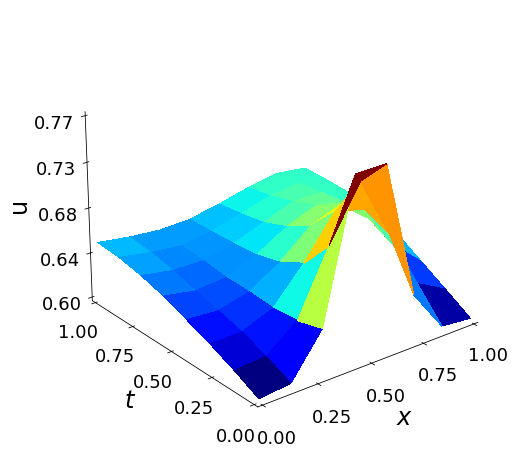

In [11]:
plot_3d(n_cell, T_terminal, speeds.detach().numpy(), "u") 
# plot_3d(n_cell, T_terminal, rhos.detach().numpy(), r"$\rho$")